In [43]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import tensorflow as tf
import altair as alt
import collections
from sklearn.model_selection import train_test_split


from src.clean_data import clean_books, clean_reviews, scale_data
from src.EDAFunction import read_reviews, read_books
from src.item_recommender import ItemRecommender
from src.CFModel import CFModel, build_model, compute_scores, book_neighbors

### Load book data

In [33]:
books_df = read_books(os.path.join('data/', 'goodreads_books_mystery_thriller_crime.json.gz'), head=False)

counting file: data/goodreads_books_mystery_thriller_crime.json.gz
current line: 0,complete
done!


In [34]:
books_df1 = books_df.copy()

In [35]:
cleaned_books = clean_books(books_df1)

In [36]:
cleaned_books.head()

,title,num_pages,is_ebook,average_rating,ratings_count,text_reviews_count
book_id,,,,,,
6066814,"Crowner Royal (Crowner John Mystery, #13)",400,0,3.93,186,15
33394837,The House of Memory (Pluto's Snitch #2),318,1,4.33,269,60
29074697,The Slaughtered Virgin of Zenopolis (Inspector Capstan #1),0,1,3.49,192,23
1902202,"Dead in the Morning (Patrick Grant, #1)",0,0,3.3,52,8
9671977,Aristotele e i misteri di Eleusi,659,0,3.54,22,3


In [ ]:
# scaled_df = scale_data(cleaned_books1)
# len(scaled_df)

In [ ]:
# rec = ItemRecommender()
# rec_model = rec.fit(scaled_df) #the computation complexity is 4 billion (200K books in total)

### Load review data

In [2]:
reviews_df = read_reviews(os.path.join('data/', 'goodreads_reviews_mystery_thriller_crime.json.gz'))

counting file: data/goodreads_reviews_mystery_thriller_crime.json.gz
current line: 0,1000000,complete
done!


In [4]:
cleaned_reviews = clean_reviews(reviews_df)

/Users/elainewu/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


remapping the ids


In [5]:
cleaned_reviews.head(2)

,review_id,user_id,book_id,rating,timestamp,n_votes,n_comments,old_user_id,old_book_id
620327,d23dc89ab32cd864e54d18369751163b,168861,77248,3,2001-01-01 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,196084
620326,c7613da4cbd48baa83efec99b4dd6a41,168861,196059,3,2001-01-11 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,79030


### delete book data which doesn't exist in review

In [45]:
book_ids = list(cleaned_reviews.old_book_id.unique())
cleaned_books1 = cleaned_books.loc[book_ids]
len(cleaned_books1)

214260

### build sparse matrix and baseline model

In [58]:
from src.CFModel import CFModel, build_model, compute_scores, book_neighbors
model = build_model(cleaned_reviews, embedding_dim=3, init_stddev=0.5)


 iteration 2000: train_error=15.524971, test_error=15.996699

[{'train_error': 15.524971, 'test_error': 15.996699}]

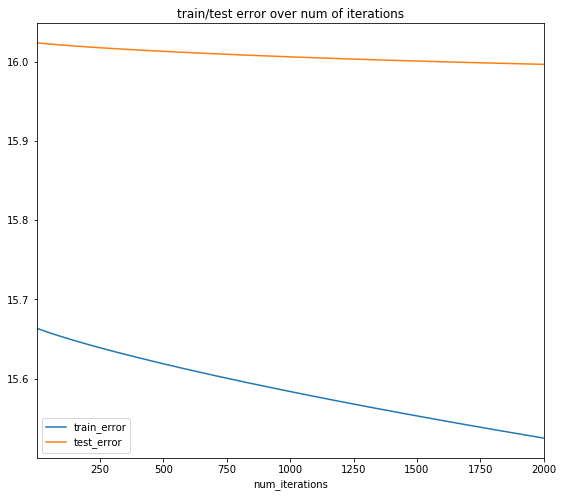

In [60]:
model.train(num_iterations=2000, learning_rate=1.)

### get neighbors of a book which contains a given substring

In [61]:
title_substring ='Harry Potter'
book_neighbors(cleaned_books1, cleaned_reviews, model, title_substring, measure='cosine', k=6)

Nearest neighbors of : Harry Potter and the Half-Blood Prince by J.K. Rowling | Summary & Study Guide.


,cosine score,titles,is_ebook,average_rating,ratings_count
book_id,,,,,
22067806,0.9999998807907104,Missing You by Harlan Coben -- Review,1,4.05,2
17406195,0.9999886155128479,Marie Magdalena 1 - Očekávaná,0,3.9,1
33808453,0.9999831914901733,Peppermint Mocha Killer (INNcredibly Sweet #13),1,4.53,154
17324260,0.9999796152114868,The Davenport Dilemma,0,4.38,8
29406489,0.9999526143074036,Forever in Ocala,1,4.35,16
3069704,0.9999433755874634,Dying to Meet You,0,3.13,15


In [229]:
cleaned_books1[cleaned_books1.title.apply(lambda x:True if 'Harry Potter' in x else False)]

,title,num_pages,is_ebook,average_rating,ratings_count,text_reviews_count
book_id,,,,,,
25572694,Harry Potter and the Half-Blood Prince by J.K. Rowling | Summary & Study Guide,0,1,5.0,2,1


### inspect neighbor clustering

In [63]:
def book_embedding_norm(models):
    """
    visualizes the norm and number of ratings of the book
    Args:
        model: a MFmodel object
    """
    if not isinstance(models, list):
        models = [models]
    df=pd.DataFrame({
        'title': cleaned_books1['title'],
        'average_rating': cleaned_books1['average_rating'],
        'ratings_count':cleaned_books1['ratings_count']
    })
    charts = []
    brush = alt.selection_interval()
    for i, model in enumerate(models):
        norm_key = 'norm' +str(i)
        df[norm_key] = np.linalg.norm(model.embeddings['book_id'], axis=1)
        nearest = alt.selection(
                type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
                empty='none')
        base = alt.Chart().mark_circle().encode(
                x='ratings_count',
                y=norm_key,
               color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
            ).properties(
            selection=nearest).add_selection(brush)
        text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='ratings_count', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
        charts.append(alt.layer(base, text))
    return alt.hconcat(*charts, data=df)
    
    

In [64]:
book_embedding_norm(model)

ValueError: Length of values does not match length of index

In [9]:
from scipy.sparse import csr_matrix
# csr_matrix((train_reviews.rating.values, (train_reviews.user_id.values, train_reviews.book_id.values)), 
#            shape=(len(train_reviews.user_id.unique()), len(train_reviews.book_id.unique()))).toarray()

#rating matrix will be too sparse if we convert the rating data into a pd pivot table 
#rating_mat = pd.pivot_table(train_reviews, values=['rating'], index=['user_id'], columns =['book_id'])